# **SECTION 0: Imports**

In [178]:
import sys

import random

import numpy as np

import pandas as pd 

from collections import Counter

from sklearn import model_selection
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from scipy import stats

import matplotlib.pyplot as plt


import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace

import pandas as pd 
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier

import os
import re

import nltk
nltk.download("stopwords") 
from nltk.corpus import stopwords

import time

%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# **SECTION 1: Data Preprocessing**

## **Data Acquisition Step**

### IMDB Reviews Dataset

In [179]:
# Download and extract the IMDB dataset
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz 
!tar xfz aclImdb_v1.tar.gz

--2022-11-09 04:53:46--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz.3’

aclImdb_v1.tar.gz.3 100%[===================>]  80.23M  20.7MB/s    in 5.3s    

2022-11-09 04:53:52 (15.3 MB/s) - ‘aclImdb_v1.tar.gz.3’ saved [84125825/84125825]



In [180]:
trainDir = 'aclImdb/train/'
testDir = 'aclImdb/test/'
vocabFile = 'aclImdb/imdb.vocab'
reviewWordFrequenciesTrain = 'aclImdb/train/labeledBow.feat'
reviewWordFrequenciesTest = 'aclImdb/test/labeledBow.feat'

def create_vocab_list(vocabFile):
  with open(vocabFile) as vf:
    vocabList = [word.rstrip() for word in vf]

  return vocabList

def generate_tokens(text):
  text = text.lower()
  text = re.sub("\\s", " ", text) # remove multiple whitespace characters (leave one whitespace)
  tokens = text.split(' ')

  return tokens

def count_word_frequencies(dirnames, vocabList):
  wordFrequencies = dict.fromkeys(vocabList, 0)
  totalFiles = 0

  for dirname in dirnames:
    # Review files: neg/0_3.txt neg/10000_4.txt neg/10001_4.txt ...
    for y_val, y_label in enumerate(['neg', 'pos']):
        y_dir = os.path.join(dirname, y_label)

        # Generate lists of tokens of each review
        for filename in os.listdir(y_dir):
            filepath = os.path.join(y_dir, filename)
            with open(filepath) as review:
              reviewTokenized = generate_tokens(review.read())
              for word in set(reviewTokenized):
                if word in wordFrequencies:
                  wordFrequencies[word] += 1
            totalFiles += 1

  return totalFiles, wordFrequencies  

def find_popular_words(wordFrequencies, totalFiles):
  popularWords = [word for word, count in wordFrequencies.items() if ((count/totalFiles) * 100) >= 1.0 and ((count/totalFiles) * 100) < 50.0]

  return popularWords

def remove_stop_words(vocabList):
  stopWords = set(stopwords.words('english'))
  excludedStopWordsList = [vocab for vocab in vocabList if not vocab in stopWords]

  return excludedStopWordsList

def remove_word_contractions(vocabList):
  excludedContractions = [vocab for vocab in vocabList if vocab.isalnum()]

  return excludedContractions

def create_index_word_tuples(vocabFile, filteredVocabList):
  with open(vocabFile) as vf:
    indexedWords = list(zip(range(1, len(vocabList)), vocabList))
    filteredWords = [indexedWord for indexedWord in indexedWords if indexedWord[1] in filteredVocabList]

  return filteredWords

def create_df(index_word_tuples, wordFrequenciesFile, features):
  index_word_dictionary = dict((index, word) for index, word in index_word_tuples)
  indexWordNames = list(index_word_dictionary.keys())
  wordNames = list(index_word_dictionary.values())
  wordNames.append('label')

  with open(wordFrequenciesFile) as wf:
    lines = wf.readlines()
    length = len(lines)
    data = np.zeros([length, len(features)+1]) # last column is for sentiment
    
    for row, line in enumerate(lines): # index starts at 0, labeledBow.feat starts at 1
      tokenizedLine = line.split()
      sentiment = int(tokenizedLine[0])

      for i in range(1, len(tokenizedLine)):
        splitToken = tokenizedLine[i].split(":")
        wordNumber = int(splitToken[0])
        wordFreq = int(splitToken[1])

        if wordNumber in indexWordNames:
          column = indexWordNames.index(wordNumber)
          data[row][column] = wordFreq
      data[row][-1] = 1 if sentiment > 4 else 0 
    df = pd.DataFrame(data, columns=wordNames)
    df[wordNames] = df[wordNames].astype(int)
    data = data.astype(int)

  return df, data

def filter(z_scores, maxVal, minVal):
  colsToKeep = []
  colsToRemove = []

  for index, z_score in enumerate(z_scores):
    if minVal <= z_score and z_score <= maxVal:
      colsToRemove.append(index)
    else:
      colsToKeep.append(index)

  return colsToKeep, colsToRemove

def removeColumns(data, colsToKeep):
  filteredData = data[:, colsToKeep]

  return filteredData

def get_X_y(X_y_data):
  numRows, numCols = np.shape(X_y_data)
  X = X_y_data[:, 0: numCols-1]
  y = X_y_data[:, numCols-1]
  return X, y

In [181]:
# Create Train dataframe/numpy
vocabList = create_vocab_list(vocabFile)
totalFiles, wordFrequencies = count_word_frequencies([testDir, trainDir], vocabList)
popularWordsList = find_popular_words(wordFrequencies, totalFiles)
excludedStopWordsList = remove_stop_words(popularWordsList)
excludedContractions = remove_word_contractions(excludedStopWordsList)
index_word_tuples = create_index_word_tuples(vocabFile, excludedContractions)

In [182]:
# Initial train dataset (no feature filtering) 
train_df_imdb, train_numpy_data_imdb = create_df(index_word_tuples, reviewWordFrequenciesTrain, excludedContractions)
print(train_numpy_data_imdb.shape)
initialFeatures = train_df_imdb.columns.tolist()
initialFeatures.pop()
train_df_imdb

(25000, 1300)


,film,like,good,even,time,would,story,really,see,well,...,deserve,gotten,teen,starting,creating,keeping,manage,discover,learned,label
0,0,0,0,2,0,1,0,2,0,1,...,0,0,0,0,0,0,0,0,0,1
1,1,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,2,0,2,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,2,2,1,4,0,2,1,3,0,1,...,0,0,0,0,1,0,0,0,0,0
24996,2,0,0,0,0,0,2,0,1,0,...,0,0,0,0,0,0,0,0,0,0
24997,3,1,0,0,0,0,0,2,1,2,...,1,0,0,0,0,0,0,0,0,0
24998,1,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [183]:
# Initial test dataset (no feature filtering) 
test_df_imdb, test_numpy_data_imdb = create_df(index_word_tuples, reviewWordFrequenciesTest, excludedContractions)
print(test_numpy_data_imdb.shape)
test_df_imdb

(25000, 1300)


,film,like,good,even,time,would,story,really,see,well,...,deserve,gotten,teen,starting,creating,keeping,manage,discover,learned,label
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,1,2,3,0,4,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2,0,0,2,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1
3,2,2,0,0,0,0,0,2,2,3,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,1,4,1,1,0,3,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
24996,2,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
24997,3,0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24998,0,0,0,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Initial features: [(0, 'film', -0.8505283991416361), (1, 'like', -14.88280371028484), (2, 'good', 5.141627946358131), (3, 'even', 3.2835122461201127), (4, 'time', -11.025780683418553), (5, 'would', 3.3030042376312387), (6, 'story', -5.601353381890354), (7, 'really', 5.542239532528722), (8, 'see', -7.136303456137573), (9, 'well', -3.3989418468321766), (10, 'much', -7.765859923452842), (11, 'get', -2.548648919476401), (12, 'people', 9.593041742938459), (13, 'bad', 4.896780681578591), (14, 'also', -0.17533315754392817), (15, 'great', 3.3305828080582023), (16, 'first', -4.082644681603089), (17, 'made', -12.073724516925822), (18, 'way', -13.62356589988532), (19, 'make', -13.596518797219318), (20, 'could', -4.871319256944941), (21, 'movies', 0.07777847471444464), (22, 'think', -0.3539350447124532), (23, 'characters', -0.14517548547034767), (24, 'character', -1.476869448949877), (25, 'watch', 6.43504416145382), (26, 'films', 5.475122979283874), (27, 'two', 8.868123769538611), (28, 'many', 1.5

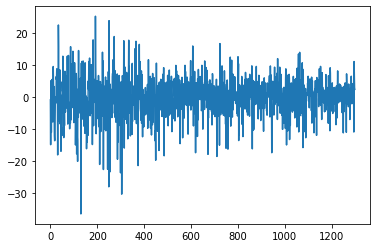

In [184]:
# Filter train dataset features

# Calculate Z-Score of Train set
numRows, numCols = np.shape(train_numpy_data_imdb)
X_imdb_train = train_numpy_data_imdb[:, 0: numCols-1] # Excluding the label column
y_imdb_train = train_numpy_data_imdb[:, numCols-1]

X_imdb_standardized = (X_imdb_train - X_imdb_train.mean(axis=0)) / X_imdb_train.std(axis=0)
y_imdb_standardized = (y_imdb_train - y_imdb_train.mean(axis=0)) / y_imdb_train.std(axis=0)

z_scores_train = (X_imdb_standardized.T @ y_imdb_standardized) / np.sqrt(numRows)
plt.plot(z_scores_train)
index_features_zscores = []
for index, (feature, zscore) in enumerate(zip(initialFeatures, z_scores_train)):
  index_features_zscores.append((index, feature, zscore))
print("Initial features:", index_features_zscores)
keptIndices, indicesForRemoval = filter(z_scores_train, 7, -7)

final_features_index_features_zscores = []
for index, item in enumerate(index_features_zscores):
  if index in keptIndices:
    final_features_index_features_zscores.append(item)
sorted_final_features_index_features_zscores = sorted(final_features_index_features_zscores, key=lambda tup: tup[2])
most_positive_final_features_index_features_zscores = sorted_final_features_index_features_zscores[: 10]
most_negative_final_features_index_features_zscores = sorted_final_features_index_features_zscores[-10 :]
top_zscores = most_positive_final_features_index_features_zscores + most_negative_final_features_index_features_zscores
final_features = [i[1] for i in final_features_index_features_zscores]

# print("Final features:", final_features_index_features_zscores)
# print("Sorted final feature list", sorted_final_features_index_features_zscores)
# print("Final features: ", final_features)
print("Most negative zscores:", most_positive_final_features_index_features_zscores)
print("Most positive zscores:", most_negative_final_features_index_features_zscores)
print("Initial Feature Count:", len(initialFeatures))
print("Final Feature Count:", len(keptIndices))

In [185]:
# Feature-scaled train datasets
X_imdb_filtered_train = removeColumns(train_numpy_data_imdb, keptIndices)
y_imdb_filtered_train = train_numpy_data_imdb[:, numCols-1]
X_imdb_filtered_train
print(X_imdb_filtered_train.shape)
print(train_numpy_data_imdb.shape[1] - 1)

(25000, 257)
1299


In [186]:
# Random feature-scaled train datasets

randomIndicesToKeep = []
for i in range(0, X_imdb_filtered_train.shape[1]):
  n = random.randint(0, train_numpy_data_imdb.shape[1]-2)
  randomIndicesToKeep.append(n)
X_random_imdb_filtered_train = removeColumns(train_numpy_data_imdb, randomIndicesToKeep)
y_random_imdb_filtered_train = train_numpy_data_imdb[:, numCols-1]
X_imdb_filtered_train
print(X_imdb_filtered_train.shape)

(25000, 257)


In [187]:
# Feature-scaled test
X_imdb_filtered_test, y_imdb_filtered_test = get_X_y(test_numpy_data_imdb)
X_imdb_filtered_test = removeColumns(X_imdb_filtered_test, keptIndices)
X_imdb_filtered_test.shape

(25000, 257)

In [188]:
# Random feature-scaled test datasets
X_random_imdb_filtered_test, y_random_imdb_filtered_test = get_X_y(test_numpy_data_imdb)
X_random_imdb_filtered_test = removeColumns(X_random_imdb_filtered_test, randomIndicesToKeep)
X_random_imdb_filtered_test.shape

(25000, 257)

### 20-News Groups

In [189]:
category0 = 'comp.graphics'
category1 = 'rec.sport.hockey'
category2 = 'sci.crypt'
category3 = 'soc.religion.christian'
categories = [category0, category1, category2, category3]
remove = ['headers', 'footers', 'quotes']
twenty_train = fetch_20newsgroups(subset='train', categories=categories, remove=remove, random_state=42)
twenty_test = fetch_20newsgroups(subset='test', categories=categories, remove=remove, random_state=42)

textsTrain = twenty_train.data
labelsTrain = twenty_train.target.tolist()
textsTest = twenty_test.data
labelsTest = twenty_test.target.tolist()
totalTrainTexts = len(textsTrain)
totalTestTexts = len(textsTest)
totalTexts = totalTrainTexts + totalTestTexts

twenty_train_category0 = fetch_20newsgroups(subset='train', categories=[category0], remove=remove, random_state=42)
twenty_test_category0 = fetch_20newsgroups(subset='test', categories=[category0], remove=remove, random_state=42)
dataTrainCategory0 = twenty_train_category0.data
dataTestCategory0 = twenty_test_category0.data
labelsTrainCategory0 = twenty_train_category0.target.tolist()
labelsTestCategory0 = twenty_test_category0.target.tolist()

twenty_train_category1 = fetch_20newsgroups(subset='train', categories=[category1], remove=remove, random_state=42)
twenty_test_category1 = fetch_20newsgroups(subset='test', categories=[category1], remove=remove, random_state=42)
dataTrainCategory1 = twenty_train_category1.data
dataTestCategory1 = twenty_test_category1.data
labelsTrainCategory1 = twenty_train_category1.target.tolist()
labelsTestCategory1 = twenty_test_category1.target.tolist()

twenty_train_category2 = fetch_20newsgroups(subset='train', categories=[category2], remove=remove, random_state=42)
twenty_test_category2 = fetch_20newsgroups(subset='test', categories=[category2], remove=remove, random_state=42)
dataTrainCategory2 = twenty_train_category2.data
dataTestCategory2 = twenty_test_category2.data
labelsTrainCategory2 = twenty_train_category2.target.tolist()
labelsTestCategory2 = twenty_test_category2.target.tolist()

twenty_train_category3 = fetch_20newsgroups(subset='train', categories=[category3], remove=remove, random_state=42)
twenty_test_category3 = fetch_20newsgroups(subset='test', categories=[category3], remove=remove, random_state=42)
dataTrainCategory3 = twenty_train_category3.data
dataTestCategory3 = twenty_test_category3.data
labelsTrainCategory3 = twenty_train_category3.target.tolist()
labelsTestCategory3 = twenty_test_category3.target.tolist()

def generate_tokens(text):
  text = text.lower()
  text = re.sub("\\s", " ", text) # remove multiple whitespace characters (leave one whitespace)
  tokens = text.split(' ')

  return tokens

def generate_vocab(textsList):
  vocab = set()
  
  for texts in textsList:
    for text in texts:
      tokenizedText = generate_tokens(text)
      for token in tokenizedText:
        if token.isalpha():
          vocab.add(token.lower())

  return vocab

def get_word_frequencies(textsList, categoriesList, vocab):
  # category_wordList = []
  wordFileFrequencyCount = dict.fromkeys(vocab, 0)

  for texts, categories in zip(textsList, categoriesList):
    for text, category in zip(texts, categories):
      temp = dict()
      tokenizedText = generate_tokens(text)

      for token in set(tokenizedText):
        if token.isalpha():
          if token.lower() in wordFileFrequencyCount:
            wordFileFrequencyCount[token.lower()] += 1
      # category_wordList.append((category, dict(Counter(tokenizedText))))

  return wordFileFrequencyCount

def find_popular_words(wordFileFrequencyCount, totalTexts):
  updatedWordFileFrequencyCount = wordFileFrequencyCount.copy()

  for word, count in wordFileFrequencyCount.items():
    if not ((count/totalTexts) * 100) >= 1.0:
      updatedWordFileFrequencyCount.pop(word, None)

  return list(updatedWordFileFrequencyCount.keys())

def filter_stop_words(vocabList):
  stopWords = set(stopwords.words('english'))
  excludedStopWordsList = [vocab for vocab in vocabList if not vocab in stopWords]

  return excludedStopWordsList

def get_filtered_vocab_list(textsTrain, textsTest, trainLabels, testLabels):
  vocabList = generate_vocab([textsTrain, textsTest])
  wordFileFrequencyCount = get_word_frequencies([textsTrain, textsTest], [list(trainLabels), list(testLabels)], vocabList)
  popularWordsList = find_popular_words(wordFileFrequencyCount, totalTexts)
  excludedStopWordsList = filter_stop_words(popularWordsList)
  
  return excludedStopWordsList

def obtain_frequency_count(textsList, labelsList, vocab):
  frequenciesList = []

  for text, label in zip(textsList, labelsList):
    frequencies = dict.fromkeys(range(len(vocab)), 0)
    labelIndex = len(frequencies)
    tokenizedText = generate_tokens(text)

    for token in tokenizedText:
      if token.isalpha() and token in vocab:
        wordIndex = vocab.index(token)
        if wordIndex in frequencies:
          frequencies[wordIndex] += 1
    frequenciesList.append(frequencies)
    frequencies[labelIndex] = label

  return frequenciesList

def create_df(frequenciesList, vocabList):
  wordNames = vocabList.copy()
  wordNames.append("label")
  data = np.zeros([len(frequenciesList), len(wordNames)]) # last column is for category

  for row, frequencies in enumerate(frequenciesList):
    for column, frequency in frequencies.items():
      data[row][column] = frequency
  df = pd.DataFrame(data, columns=wordNames)
  df[wordNames] = df[wordNames].astype(int)

  return df, data

def get_X_y(X_y_data):
  numRows, numCols = np.shape(X_y_data)
  X_train = X_y_data[:, 0: numCols-1]
  y_train = X_y_data[:, numCols-1]
  return X_train, y_train

In [190]:
filteredCategory0Vocab = get_filtered_vocab_list(dataTrainCategory0, dataTrainCategory0, labelsTrainCategory0, labelsTestCategory0) 
filteredCategory1Vocab = get_filtered_vocab_list(dataTrainCategory1, dataTrainCategory1, labelsTrainCategory1, labelsTestCategory1) 
filteredCategory2Vocab = get_filtered_vocab_list(dataTrainCategory2, dataTrainCategory2, labelsTrainCategory2, labelsTestCategory2) 
filteredCategory3Vocab = get_filtered_vocab_list(dataTrainCategory3, dataTrainCategory3, labelsTrainCategory3, labelsTestCategory3) 

totalFilteredVocab = []
totalFilteredVocab.extend(filteredCategory0Vocab)
totalFilteredVocab.extend(filteredCategory1Vocab)
totalFilteredVocab.extend(filteredCategory2Vocab)
totalFilteredVocab.extend(filteredCategory3Vocab)
totalFilteredVocab = list(set(totalFilteredVocab))

trainFrequencies = obtain_frequency_count(textsTrain, labelsTrain, totalFilteredVocab)
testFrequencies = obtain_frequency_count(textsTest, labelsTest, totalFilteredVocab)

In [191]:
train_df_twenty, train_numpy_data_twenty = create_df(trainFrequencies, totalFilteredVocab)
train_df_twenty

,windows,could,paul,come,read,likely,based,agency,set,scheme,...,color,designed,say,current,home,within,wrong,different,response,label
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,3
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2373,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2374,0,0,0,0,0,1,0,0,0,0,...,0,1,2,0,0,0,0,0,0,2
2375,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
2376,0,2,0,1,3,1,0,0,1,0,...,0,0,3,0,0,0,0,0,0,2


In [192]:
# One-hot encoding

one_hot_train_df_twenty = pd.get_dummies(train_df_twenty['label'])
train_df_twenty_nolabel = train_df_twenty.drop('label', axis=1)
train_df_twenty_nolabel

,windows,could,paul,come,read,likely,based,agency,set,scheme,...,wiretap,color,designed,say,current,home,within,wrong,different,response
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2373,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2374,0,0,0,0,0,1,0,0,0,0,...,0,0,1,2,0,0,0,0,0,0
2375,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2376,0,2,0,1,3,1,0,0,1,0,...,0,0,0,3,0,0,0,0,0,0


In [193]:
test_df_twenty, test_numpy_data_twenty = create_df(testFrequencies, totalFilteredVocab)
test_df_twenty

,windows,could,paul,come,read,likely,based,agency,set,scheme,...,color,designed,say,current,home,within,wrong,different,response,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,3
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1577,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1578,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,3
1579,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
1580,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


In [194]:
# Feature selection
infoScores = []
numFeatures = 25
top_20_twenty_features = []

for labelIndex, labelCol in enumerate(one_hot_train_df_twenty):
  features_metrics = []
  for featureIndex, featureName in enumerate(train_df_twenty_nolabel.columns):
    metric = metrics.adjusted_mutual_info_score(train_df_twenty_nolabel[featureName], one_hot_train_df_twenty[labelIndex])
    feature_metric = (featureName, metric)
    features_metrics.append(feature_metric)
  features_metrics.sort(key=lambda feature_metric: feature_metric[1])
  largest_features_metrics = features_metrics[-numFeatures:]
  infoScores.extend(list(list(zip(*largest_features_metrics))[0]))
  
  # Extraction of top 20 features for the 20 news group dataset.
  # Selecting top 5 for each category.
  top_5_features_of_category = largest_features_metrics[-5:]
  top_5_features_of_category.sort(reverse=True, key=lambda x: x[1])
  for feature in top_5_features_of_category:
    top_20_twenty_features.append(feature)


featuresToKeep = set(infoScores)
featuresToRemove = []
for feature in list(train_df_twenty_nolabel.columns):
  if feature not in featuresToKeep:
    featuresToRemove.append(feature)

# Extracting the feature names from the tuples.
top_20_twenty_features_names = []
for feature in top_20_twenty_features:
  top_20_twenty_features_names.append(feature[0])

In [195]:
train_df_twenty_filtered = train_df_twenty.drop(featuresToRemove, axis=1)
test_df_twenty_filtered = test_df_twenty.drop(featuresToRemove, axis=1)

# Extracting indexes of features we want to keep for the heatmap (top 20 features).
twenty_filtered_column_names = list(train_df_twenty_filtered.columns)
top_20_twenty_features_indexes = []
for i in top_20_twenty_features_names:
  top_20_twenty_features_indexes.append(twenty_filtered_column_names.index(i))

In [196]:
X_train_twenty, y_train_twenty = get_X_y(train_df_twenty_filtered.to_numpy())
y_train_twenty_one_hot = pd.get_dummies(train_df_twenty_filtered['label']).to_numpy()
type(X_train_twenty)
type(y_train_twenty_one_hot)
print(X_train_twenty.shape, y_train_twenty_one_hot.shape)

(2378, 93) (2378, 4)


In [197]:
X_test_twenty, y_test_twenty = get_X_y(test_df_twenty_filtered.to_numpy())
y_test_twenty_one_hot = pd.get_dummies(test_df_twenty_filtered['label']).to_numpy()
y_test_twenty_one_hot

array([[0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       ...,
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1]], dtype=uint8)

# **SECTION 2: Machine Learning Algorithm Implementations**

## **Logistic Regression**

In [198]:
class LogisticRegression:
    def __init__(self, addBias=True, learningRate=0.005, epsilon=1e-4, maxIterations=1000):
        self.addBias = addBias
        self.learningRate = learningRate
        self.epsilon = epsilon
        self.maxIterations = maxIterations

    def logistic(self, a):
      yh = 1. / (1 + np.exp(-a))

      return yh

    def fit(self, X_train, y_train):
      if self.addBias:
        X_train = np.column_stack([X_train, np.ones(X_train.shape[0])]) # Adding bias at beginning if 1's are in left-most column FLIP THESE B/c a comment on ed

      N, D = X_train.shape
      self.w = np.zeros(D)
      gradient = np.inf
      
      t = 0
      # Gradient descent
      while np.linalg.norm(gradient) > self.epsilon and t < self.maxIterations:
        # Compute gradients
        yh = self.logistic(np.dot(X_train, self.w))
        gradient = (1 / N) * np.dot(X_train.T, yh-y_train)

        # Update parameters
        self.w = self.w - (self.learningRate * gradient)
        t += 1

    def predict(self, X_test):
      Nt = X_test.shape[0]
      if self.addBias: 
        X_test = np.column_stack([X_test, np.ones(Nt)])

      yh = self.logistic(np.dot(X_test, self.w))
      predictionClasses = [1 if probability > 0.5 else 0 for probability in yh]

      return yh, predictionClasses

## **Multiclass Regression**

In [199]:
class MultiClassLogisticRegression:
    def __init__(self, nFeatures, nClasses):
        self.W = np.random.rand(nFeatures, nClasses)

    def predict(self, X):
        y_pred = np.exp(np.matmul(X, self.W))
        return y_pred / y_pred.sum(axis=1).reshape(X.shape[0], 1)

    def grad(self, X, y):
        return np.matmul(X.transpose(), self.predict(X) - y)

    def ce(self, X, y):
        return -np.sum(y * np.log(self.predict(X)))

    def fit(self, X, y, X_valid=None, y_valid=None, lr=0.0001, niter=2000):
        losses_train = np.zeros(niter)
        losses_valid = np.zeros(niter)
        last_loss_train = sys.maxsize
        last_loss_valid = sys.maxsize
        final_niter = niter
        for i in range(niter):
            self.W = self.W - lr * self.grad(X, y)
            loss_train = self.ce(X, y)
            losses_train[i] = loss_train
            if X_valid is not None and y_valid is not None:
                loss_valid = self.ce(X_valid, y_valid)
                losses_valid[i] = loss_valid
                if last_loss_train < loss_train or last_loss_valid < loss_valid:
                  final_niter = i
                  break
                last_loss_train = loss_train
                last_loss_valid = loss_valid
        return losses_train, losses_valid, final_niter

    def check_grad(self, X, y):
        N, C = y.shape
        D = X.shape[1]

        diff = np.zeros((D, C))

        W = self.W.copy()

        for i in range(D):
            for j in range(C):
                epsilon = np.zeros((D, C))
                epsilon[i, j] = np.random.rand() * 1e-4

                self.W = self.W + epsilon
                J1 = self.ce(X, y)
                self.W = W

                self.W = self.W - epsilon
                J2 = self.ce(X, y)
                self.W = W

                numeric_grad = (J1 - J2) / (2 * epsilon[i, j])
                derived_grad = self.grad(X, y)[i, j]

                diff[i, j] = np.square(derived_grad - numeric_grad).sum() / \
                             np.square(derived_grad + numeric_grad).sum()

        return diff.sum()

# **SECTION 3: Experiments**

## **Part 0 - Best learning rate for Logistic Regression on the IMDB reviews dataset.**

In [200]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X_imdb_filtered_train, y_imdb_filtered_train, train_size=0.8, test_size=0.2, random_state=11, shuffle=True)
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)

(20000, 257) (20000,)
(5000, 257) (5000,)


In [201]:
alphas = [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50]
alpha_accuracies = []
for a in alphas:
    logisticRegression = LogisticRegression(learningRate=a, maxIterations=1000)
    logisticRegression.fit(X_train, y_train)
    y_valid_pred, y_valid_pred_classes = logisticRegression.predict(X_valid)
    accuracy = np.sum(y_valid_pred_classes == y_valid)/len(y_valid)
    alpha_accuracies.append((a, accuracy))
print(alpha_accuracies)
best_valid_alpha_logistic = sorted(alpha_accuracies, key=lambda x: x[1], reverse=True)[0][0]
print(best_valid_alpha_logistic)

[(0.01, 0.8024), (0.05, 0.831), (0.1, 0.8366), (0.5, 0.8442), (1, 0.8438), (5, 0.8176), (10, 0.7968), (50, 0.7728)]
0.5


## Training times for LR vs KNN on IMDB reviews

In [202]:
# Logistic Regression on IMDB
logisticRegression = LogisticRegression(learningRate=best_valid_alpha_logistic, maxIterations=1000)
start = time.time()
logisticRegression.fit(X_imdb_filtered_train, y_imdb_filtered_train)
end = time.time()
probabilities, predictionClasses = logisticRegression.predict(X_imdb_filtered_test)
accuracy = np.sum(y_imdb_filtered_test == predictionClasses) / len(y_imdb_filtered_test)
print(f"LR Training time: {round(end-start, 2)}s")

LR Training time: 11.75s


In [203]:
# K-NN on IMDB
knn = KNeighborsClassifier(n_neighbors=15)
start = time.time()
knn.fit(X_imdb_filtered_train, y_imdb_filtered_train)
end = time.time()
predictions = knn.predict(X_imdb_filtered_test) 
print(f"KNN Training time: {round(end-start, 2)}s")

KNN Training time: 0.01s


## Training times for MLR vs KNN on 20 Newsgroups

In [204]:
def evaluate(y, y_pred):
    accuracy = sum(y_pred.argmax(axis=1) == y.argmax(axis=1))
    accuracy = accuracy / y.shape[0]
    return accuracy

In [205]:
# Multiclass Regression on 20 Newsgroups
N, C = y_train_twenty_one_hot.shape
X_train_twenty = preprocessing.scale(X_train_twenty) # standardize input data
D = X_train_twenty.shape[1]
MLR_classifier = MultiClassLogisticRegression(D, C)
start = time.time()
ce_train, ce_valid, final_niter = MLR_classifier.fit(X_train_twenty, y_train_twenty_one_hot, lr=0.0001, niter=250)
end = time.time()
predictions = MLR_classifier.predict(X_test_twenty)

print(f"MLR Training time: {round(end-start, 2)}s")

MLR Training time: 0.83s


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in multiply
  del sys.path[0]


In [206]:
# K-NN on 20 Newsgroups
KNN_classifier = KNeighborsClassifier(n_neighbors=15)
start = time.time()
KNN_classifier.fit(X_train_twenty, y_train_twenty_one_hot)
end = time.time()
predictions = KNN_classifier.predict(X_test_twenty)

print(f"KNN Training time: {round(end-start, 2)}s")

KNN Training time: 0.0s


## **Part 1 - Horizontal bar plot showing the top 20 IMDB features with the most positive/negative z-scores.**



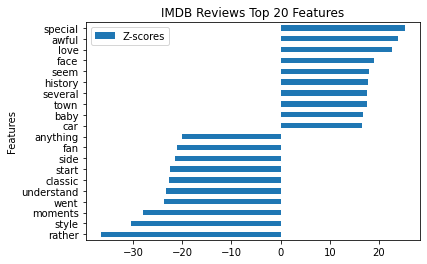

In [207]:
features = list(list(zip(*top_zscores))[1])
zscores = list(list(zip(*top_zscores))[2])

# Create data frame
zscoreData = {"Features": features, "Z-scores": zscores}
zscoreDF = pd.DataFrame(data=zscoreData);

# Plot graph
zscoreDF.plot.barh(x='Features', y='Z-scores', title="IMDB Reviews Top 20 Features");
plt.show(block=True)

## **Part 2: Convergence plot for Logistic and Multiclass Regression.**

### Logistic Regression

12757.0
12756.999999957878
2.7256358142363518e-24


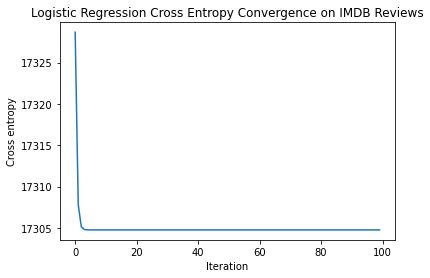

In [208]:
X, y = X_imdb_filtered_train, y_imdb_filtered_train

# Gradient evalution using small perturbation 
w = np.zeros(X.shape[1])
epsilon = np.random.randn(1)[0] * 1e-5
w1 = w + epsilon
w2 = w - epsilon
a1 = np.matmul(X, w1)
a2 = np.matmul(X, w2)
ce1 = np.sum(y * np.log1p(np.exp(-a1)) + (1-y) * np.log1p(np.exp(a1)))
ce2 = np.sum(y * np.log1p(np.exp(-a2)) + (1-y) * np.log1p(np.exp(a2)))
dw_num = (ce1 - ce2)/(2*epsilon) # approximated gradient

yh = 1/(1+np.exp(-np.matmul(X, w)))
dw_cal = np.sum(np.reshape((yh - y), (y.shape[0], 1)) * X) # analytical gradient (hand calculated)

print(dw_cal)
print(dw_num)
print((dw_cal - dw_num)**2/(dw_cal + dw_num)**2)

# Monitor loss as a function of iteration
lr = 0.01
niter = 100
ce_all = np.zeros(niter)
w = np.zeros(X.shape[1])

for i in range(niter):
  a = np.matmul(X, w)
  ce_all[i] = np.sum(y * np.log1p(np.exp(-a)) + (1-y) * np.log1p(np.exp(a))) # cross-entropy
  yh = 1 / (1 + np.exp(-a))
  dw = np.sum(np.reshape((yh - y), (y.shape[0], 1)) * X)
  dw = dw / y.shape[0]
  w = w - lr * dw

plt.plot(ce_all)
plt.ylabel("Cross entropy")
plt.xlabel("Iteration")
plt.title(f"Logistic Regression Cross Entropy Convergence on IMDB Reviews")
plt.show()

### Multiclass Regression

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in multiply
  del sys.path[0]


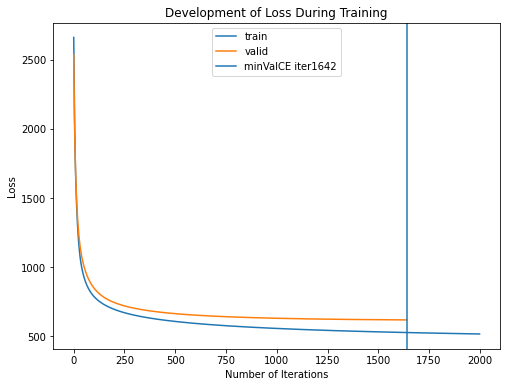

Training with 2000 iterations.
Train accuracy: 0.8242220353238016
Valid accuracy: 0.7804878048780488
Test accuracy: 0.7515802781289507
Checking Gradient: 3.119991954342058e-14


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


In [209]:
def evaluate(y, y_pred):
    accuracy = sum(y_pred.argmax(axis=1) == y.argmax(axis=1))
    accuracy = accuracy / y.shape[0]
    return accuracy

X_train, X_valid, y_train, y_valid = model_selection.train_test_split(
    X_train_twenty, y_train_twenty_one_hot, test_size = 0.5, random_state=1, shuffle=True)

N, C = y_train.shape

X_train = preprocessing.scale(X_train) # standardize input data
X_train = np.c_[X_train, np.ones(N)] # add one column to learn the linear intercept
X_valid = preprocessing.scale(X_valid)
X_valid = np.c_[X_valid, np.ones(X_valid.shape[0])]
X_test = preprocessing.scale(X_test_twenty)
X_test = np.c_[X_test, np.ones(X_test.shape[0])]

D = X_train.shape[1]

mlr = MultiClassLogisticRegression(D, C)

# Checking gradient.
check_gradient = mlr.check_grad(X_train, y_train)

ce_train, ce_valid, final_niter = mlr.fit(X_train, y_train, X_valid, y_valid)
ce_train = ce_train.copy()[:final_niter+1]
ce_valid = ce_valid.copy()[:final_niter+1]
optimal_niter = ce_valid.argmin()

# Creating loss plot over iterations.
fig = plt.figure(figsize=(8,6))
plt.plot(ce_train, label='train')
plt.plot(ce_valid, label='valid')
plt.axvline(x=optimal_niter, label=f"minValCE iter{optimal_niter}")
plt.legend()
plt.title("Development of Loss During Training")
plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.show()

# Computing accuracy on training, validation and testing sets.
train_accuracy = evaluate(mlr.predict(X_train), y_train)
valid_accuracy = evaluate(mlr.predict(X_valid), y_valid)
test_accuracy = evaluate(mlr.predict(X_test), y_test_twenty_one_hot)

print('Training with ' + str(final_niter) + ' iterations.')
print('Train accuracy: ' + str(train_accuracy))
print('Valid accuracy: ' + str(valid_accuracy))
print('Test accuracy: ' + str(test_accuracy))
print('Checking Gradient: ' + str(check_gradient))

## **Part 3 - Logistic Regression receiver operating characteristic curve (ROC).**

In [210]:
# Making Logistic Regression predictions on z-score feature-filtered IMDB dataset

classifier = LogisticRegression(learningRate=best_valid_alpha_logistic, maxIterations=1000)
classifier.fit(X_imdb_filtered_train, y_imdb_filtered_train)
probabilities, predictionClasses = classifier.predict(X_imdb_filtered_test)
accuracy = np.sum(y_imdb_filtered_test == predictionClasses) / len(y_imdb_filtered_test)
print("Logistic Regression prediction accuracy for z-score filtered features: ", accuracy)

Logistic Regression prediction accuracy for z-score filtered features:  0.84048


In [211]:
# Making Logistic Regression predictions on randomly selected IMDB dataset

classifier = LogisticRegression(learningRate=best_valid_alpha_logistic, maxIterations=1000)
classifier.fit(X_random_imdb_filtered_train, y_random_imdb_filtered_train)
probabilities, predictionClasses = classifier.predict(X_random_imdb_filtered_test)
randomAccuracy = np.sum(y_random_imdb_filtered_test == predictionClasses) / len(y_random_imdb_filtered_test)
print("Logistic Regression prediction accuracy for randomly selected features: ", randomAccuracy)

Logistic Regression prediction accuracy for randomly selected features:  0.728


In [212]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_imdb_filtered_train, y_imdb_filtered_train)

predictions = knn.predict(X_imdb_filtered_test)
knnAccuracy = np.sum(y_imdb_filtered_test == predictions) / len(y_imdb_filtered_test)
print("KNN prediction accuracy for z-score filtered features: ", knnAccuracy)

KNN prediction accuracy for z-score filtered features:  0.68956


In [213]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

perf = {}

classifier = LogisticRegression(learningRate=best_valid_alpha_logistic, maxIterations=1000)
classifier.fit(X_imdb_filtered_train, y_imdb_filtered_train)
probabilities, predictionClasses = classifier.predict(X_imdb_filtered_test)
fpr, tpr, _ = roc_curve(y_imdb_filtered_test, predictionClasses)
auroc = roc_auc_score(y_imdb_filtered_test, predictionClasses)
perf["LogisticRegression"] = {'fpr':fpr, 'tpr':tpr, 'auroc':auroc}

dt = DecisionTreeClassifier(max_depth=1000)
dt.fit(X_imdb_filtered_train, y_imdb_filtered_train)
predictions = dt.predict(X_imdb_filtered_test)
fpr, tpr, _ = roc_curve(y_imdb_filtered_test, predictions)
auroc = roc_auc_score(y_imdb_filtered_test, predictions)
perf["Decision Tree"] = {'fpr':fpr, 'tpr':tpr, 'auroc':auroc}

knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_imdb_filtered_train, y_imdb_filtered_train)
predictions = knn.predict(X_imdb_filtered_test)
fpr, tpr, _ = roc_curve(y_imdb_filtered_test, predictions)
auroc = roc_auc_score(y_imdb_filtered_test, predictions)
perf["K-Nearest Neighbors"] = {'fpr':fpr, 'tpr':tpr, 'auroc':auroc}

print(perf)

{'LogisticRegression': {'fpr': array([0.     , 0.17976, 1.     ]), 'tpr': array([0.     , 0.86072, 1.     ]), 'auroc': 0.84048}, 'Decision Tree': {'fpr': array([0.     , 0.29368, 1.     ]), 'tpr': array([0.    , 0.7164, 1.    ]), 'auroc': 0.7113600000000001}, 'K-Nearest Neighbors': {'fpr': array([0.     , 0.48128, 1.     ]), 'tpr': array([0.    , 0.8604, 1.    ]), 'auroc': 0.6895600000000001}}


LogisticRegression {'fpr': array([0.     , 0.17976, 1.     ]), 'tpr': array([0.     , 0.86072, 1.     ]), 'auroc': 0.84048}
Decision Tree {'fpr': array([0.     , 0.29368, 1.     ]), 'tpr': array([0.    , 0.7164, 1.    ]), 'auroc': 0.7113600000000001}
K-Nearest Neighbors {'fpr': array([0.     , 0.48128, 1.     ]), 'tpr': array([0.    , 0.8604, 1.    ]), 'auroc': 0.6895600000000001}


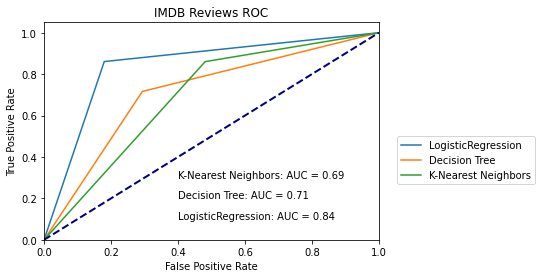

In [214]:
plt.clf()

i = 0
for modelName, modelPerf in perf.items():
  print(modelName, modelPerf)
  plt.plot(modelPerf['fpr'], modelPerf['tpr'], label=modelName)
  plt.text(0.4, i+0.1, modelName + ': AUC = '+ str(round(modelPerf['auroc'], 2)))
  i += 0.1

plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('IMDB Reviews ROC')
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="upper left")
plt.show()

## **Part 4 - A bar plot showing the AUROC of Logistic Regression and Sklearn K-NN on the test data as a function of 20%, 40%, 60%, 80%, 100% training data.**

In [215]:
# X_imdb_filtered_train, y_imdb_filtered_train
X_20_train, _, y_20_train, _ = model_selection.train_test_split(X_imdb_filtered_train, y_imdb_filtered_train, train_size=0.2, random_state=11, shuffle=True)
X_40_train, _, y_40_train, _ = model_selection.train_test_split(X_imdb_filtered_train, y_imdb_filtered_train, train_size=0.4, random_state=11, shuffle=True)
X_60_train, _, y_60_train, _ = model_selection.train_test_split(X_imdb_filtered_train, y_imdb_filtered_train, train_size=0.6, random_state=11, shuffle=True)
X_80_train, _, y_80_train, _ = model_selection.train_test_split(X_imdb_filtered_train, y_imdb_filtered_train, train_size=0.8, random_state=11, shuffle=True)
datasets = [(X_20_train, y_20_train), (X_40_train, y_40_train), (X_60_train, y_60_train), (X_80_train, y_80_train), (X_imdb_filtered_train, y_imdb_filtered_train)]

percentages = [20, 40, 60, 80, 100]
LR_aurocs = []
KNN_aurocs = []
LR_classifier = LogisticRegression(learningRate=best_valid_alpha_logistic, maxIterations=1000)
KNN_classifier = KNeighborsClassifier(n_neighbors=15)
auroc = roc_auc_score(y_imdb_filtered_test, predictions)
for X, y in datasets:
    LR_classifier.fit(X, y)
    KNN_classifier.fit(X, y)
    probabilities, predictionClasses = LR_classifier.predict(X_imdb_filtered_test)
    predictions = KNN_classifier.predict(X_imdb_filtered_test)

    LR_auroc = roc_auc_score(y_imdb_filtered_test, predictionClasses)
    KNN_auroc = roc_auc_score(y_imdb_filtered_test, predictions)

    LR_aurocs.append(LR_auroc)
    KNN_aurocs.append(KNN_auroc)

Logistic Regrresion AUROCs:  [0.83096, 0.83856, 0.8383200000000001, 0.8393200000000001, 0.84048]



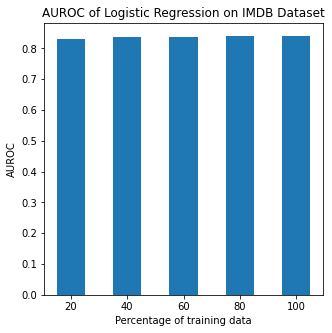

In [216]:
print("Logistic Regrresion AUROCs: ", LR_aurocs)
print()
plt.figure(figsize=(5, 5))
plt.bar(percentages, LR_aurocs, 10)
 
# Add title and axis names
plt.title('AUROC of Logistic Regression on IMDB Dataset')
plt.xlabel('Percentage of training data')
plt.ylabel('AUROC')
 
# Show graph
plt.show()

K-Nearest Neighbors AUROCs:  [0.6430400000000001, 0.67232, 0.6846, 0.6859999999999999, 0.6895600000000001]


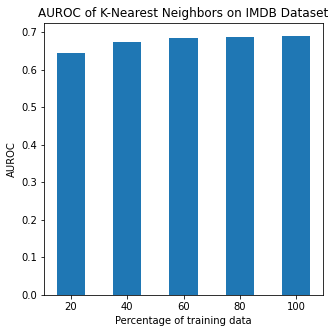

In [217]:
print("K-Nearest Neighbors AUROCs: ", KNN_aurocs)
plt.figure(figsize=(5, 5))
plt.bar(percentages, KNN_aurocs, 10)
 
# Add title and axis names
plt.title('AUROC of K-Nearest Neighbors on IMDB Dataset')
plt.xlabel('Percentage of training data')
plt.ylabel('AUROC')
 
# Show graph
plt.show()

## **Part 5 - A bar plot showing the AUROC of Multiclass Regression and Sklearn K-NN on the test data as a function of 20%, 40%, 60%, 80%, 100% training data.**



Note: if Part 5 breaks with a NaN error. Rerun it again it should work. 

In [218]:
X_20_train_twenty_news_dataset, _, y_20_train_twenty_news_dataset, _ = model_selection.train_test_split(X_train_twenty, y_train_twenty_one_hot, train_size=0.2, random_state=42, shuffle=True)
X_40_train_twenty_news_dataset, _, y_40_train_twenty_news_dataset, _ = model_selection.train_test_split(X_train_twenty, y_train_twenty_one_hot, train_size=0.4, random_state=42, shuffle=True)
X_60_train_twenty_news_dataset, _, y_60_train_twenty_news_dataset, _ = model_selection.train_test_split(X_train_twenty, y_train_twenty_one_hot, train_size=0.6, random_state=42, shuffle=True)
X_80_train_twenty_news_dataset, _, y_80_train_twenty_news_dataset, _ = model_selection.train_test_split(X_train_twenty, y_train_twenty_one_hot, train_size=0.8, random_state=42, shuffle=True)
datasets_twenty_news_dataset = [(X_20_train_twenty_news_dataset, y_20_train_twenty_news_dataset), (X_40_train_twenty_news_dataset, y_40_train_twenty_news_dataset), (X_60_train_twenty_news_dataset, y_60_train_twenty_news_dataset), (X_80_train_twenty_news_dataset, y_80_train_twenty_news_dataset), (X_train_twenty, y_train_twenty_one_hot)]

percentages = [20, 40, 60, 80, 100]
MLR_aurocs_twenty_news = []
KNN_aurocs_twenty_news = []

def mlr_knn_AUROC(X, y):
    # Multiclass Logistic Regression Classifier.
    N, C = y.shape
    X = preprocessing.scale(X) # standardize input data
    D = X.shape[1]
    MLR_classifier = MultiClassLogisticRegression(D, C)
    ce_train, ce_valid, final_niter = MLR_classifier.fit(X, y, lr=0.0001, niter=250)
    predictions = MLR_classifier.predict(X_test_twenty)
    MLR_auroc = roc_auc_score(y_test_twenty_one_hot, predictions)
    MLR_aurocs_twenty_news.append(MLR_auroc)

    # K-Nearest Neighbours Classifier.
    KNN_classifier = KNeighborsClassifier(n_neighbors=15)
    KNN_classifier.fit(X, y)
    predictions = KNN_classifier.predict(X_test_twenty)
    KNN_auroc = roc_auc_score(y_test_twenty_one_hot, predictions)
    KNN_aurocs_twenty_news.append(KNN_auroc)

for X, y in datasets_twenty_news_dataset:
    mlr_knn_AUROC(X, y)

Multiclass Logistic Regrresion AUROCs on 20 News Group Dataset:  [0.8956292197217983, 0.9123435943305978, 0.9298818223404228, 0.9341605456056808, 0.9305567311062839]



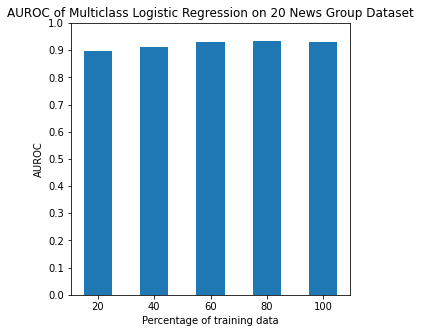

In [219]:
print("Multiclass Logistic Regrresion AUROCs on 20 News Group Dataset: ", MLR_aurocs_twenty_news)
print()
plt.figure(figsize=(5, 5))
plt.bar(percentages, MLR_aurocs_twenty_news, 10)
plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
 
# Add title and axis names
plt.title('AUROC of Multiclass Logistic Regression on 20 News Group Dataset')
plt.xlabel('Percentage of training data')
plt.ylabel('AUROC')

# Show graph
plt.show()

K-Nearest Neighbors AUROCs on 20 News Group Dataset:  [0.6276629186920689, 0.678286138663283, 0.7203381199003984, 0.7342988225552844, 0.7535529507254872]


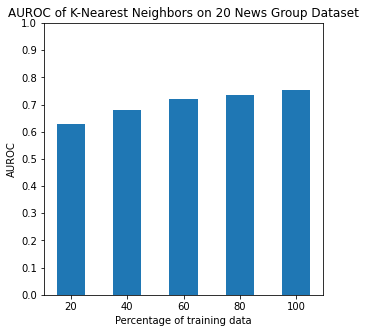

In [220]:
print("K-Nearest Neighbors AUROCs on 20 News Group Dataset: ", KNN_aurocs_twenty_news)
plt.figure(figsize=(5, 5))
plt.bar(percentages, KNN_aurocs_twenty_news, 10)
plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
 
# Add title and axis names
plt.title('AUROC of K-Nearest Neighbors on 20 News Group Dataset')
plt.xlabel('Percentage of training data')
plt.ylabel('AUROC')
 
# Show graph
plt.show()

## **Part 6 - A horizontal bar plot showing the top 20 features (10 most positive and 10 most negative) from the logistic regression on the IMDB data with the coefficient as the x-axis and the feature names (i.e., words) as the y-axis.**


In [221]:
classifier = LogisticRegression(learningRate=best_valid_alpha_logistic, maxIterations=1000, addBias=False)
classifier.fit(X_imdb_filtered_train, y_imdb_filtered_train)
probabilities, predictionClasses = classifier.predict(X_imdb_filtered_test)
accuracy = np.sum(y_imdb_filtered_test == predictionClasses) / len(y_imdb_filtered_test)
ws = classifier.w
print("Logistic Regression prediction accuracy for z-score filtered features: ", accuracy)

Logistic Regression prediction accuracy for z-score filtered features:  0.83944


In [222]:
features = final_features
weights = ws.tolist()
print(len(features), len(weights))

features_weights = list(zip(features, weights))
sorted_features_weights = sorted(features_weights, key=lambda t: t[1])
lowestWeights = sorted_features_weights[:10]
highestWeights = sorted_features_weights[-10:]
lowest_highest_Weighsts = lowestWeights + highestWeights
print(lowestWeights)
print(highestWeights)
features = list(list(zip(*lowest_highest_Weighsts))[0])
weights = list(list(zip(*lowest_highest_Weighsts))[1])
print(features)
print(weights)

257 257
[('rather', -1.492390741376359), ('style', -1.4174254066170064), ('moments', -1.2371614943112959), ('sit', -1.024972685168511), ('classic', -0.9007058731369336), ('went', -0.890906775605656), ('side', -0.860632686894706), ('understand', -0.8235363100783613), ('hero', -0.8185214634670972), ('comments', -0.8151611783521016)]
[('enjoyed', 0.6944012551018395), ('showed', 0.7030989767481385), ('using', 0.758624432269798), ('several', 0.7616229505549175), ('baby', 0.8004527976805019), ('history', 0.8102945211249731), ('face', 0.8458613756364561), ('awful', 0.8510532979983505), ('town', 0.874789621549261), ('special', 1.0613378152887818)]
['rather', 'style', 'moments', 'sit', 'classic', 'went', 'side', 'understand', 'hero', 'comments', 'enjoyed', 'showed', 'using', 'several', 'baby', 'history', 'face', 'awful', 'town', 'special']
[-1.492390741376359, -1.4174254066170064, -1.2371614943112959, -1.024972685168511, -0.9007058731369336, -0.890906775605656, -0.860632686894706, -0.8235363100

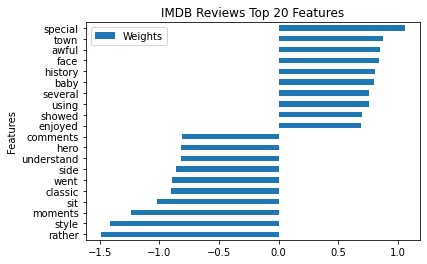

In [223]:
weightData = {"Features": features, "Weights": weights}
weightDF = pd.DataFrame(data=weightData);
weightDF.plot.barh(x='Features', y='Weights', title="IMDB Reviews Top 20 Features");

# Show graph
plt.show(block=True)

## **Part 7 - A heatmap plot showing the 5 most positive features as rows for each chosen Newsgroup.**


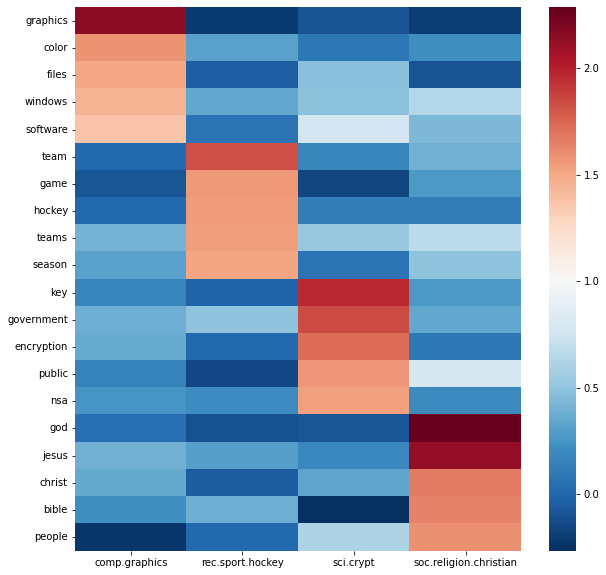

In [224]:
from seaborn import heatmap

# Extracting weights for top 20 features for the 20 news group dataset.
weights = mlr.W
cat_0_weights = []
cat_1_weights = []
cat_2_weights = []
cat_3_weights = []

for w in weights:
  cat_0_weights.append(w[0])
  cat_1_weights.append(w[1])
  cat_2_weights.append(w[2])
  cat_3_weights.append(w[3])

cat_0_weights_sorted = cat_0_weights.copy()
cat_1_weights_sorted = cat_1_weights.copy()
cat_2_weights_sorted = cat_2_weights.copy()
cat_3_weights_sorted = cat_3_weights.copy()

cat_0_weights_sorted.sort(reverse=True)
cat_1_weights_sorted.sort(reverse=True)
cat_2_weights_sorted.sort(reverse=True)
cat_3_weights_sorted.sort(reverse=True)

cat_0_weights_top_5_indexes = []
cat_1_weights_top_5_indexes = []
cat_2_weights_top_5_indexes = []
cat_3_weights_top_5_indexes = []

def top_5_indexes(sorted_weights, unsorted_weigths, index_arr):
  for w in sorted_weights[0:5]:
    index_arr.append(unsorted_weigths.index(w))

top_5_indexes(cat_0_weights_sorted, cat_0_weights, cat_0_weights_top_5_indexes)
top_5_indexes(cat_1_weights_sorted, cat_1_weights, cat_1_weights_top_5_indexes)
top_5_indexes(cat_2_weights_sorted, cat_2_weights, cat_2_weights_top_5_indexes)
top_5_indexes(cat_3_weights_sorted, cat_3_weights, cat_3_weights_top_5_indexes)
cat_weights_top_5_indexes = cat_0_weights_top_5_indexes + cat_1_weights_top_5_indexes + cat_2_weights_top_5_indexes + cat_3_weights_top_5_indexes


top_20_twenty_features_names = [twenty_filtered_column_names[x] for x in cat_weights_top_5_indexes]

weights = [weights[x] for x in cat_weights_top_5_indexes]
W_hat = weights # remove the intercept

# Creating the heatmap.
W_hat_transformed_df = pd.DataFrame(W_hat, columns=categories, index=top_20_twenty_features_names)
plt.figure(figsize = (10,10))
hmp = heatmap(W_hat_transformed_df, cmap='RdBu_r')
fig = hmp.get_figure()

## **Part 8 - Ridge and LASSO Regression**


In [225]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score, mean_squared_error
alphas = [0.01, 0.05, 0.1, 1, 50, 100, 200, 500, 1000]

### IMDB Review Dataset Mostly-Causal Features


In [226]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X_imdb_filtered_train, y_imdb_filtered_train, train_size=0.8, test_size=0.2, random_state=11, shuffle=True)
print(X_train.shape, y_train.shape)

(20000, 257) (20000,)


In [227]:
# Find best alpha for Ridge regression
alpha_accuracies = []
for a in alphas:
    ridgeRegression = Ridge(alpha=a)
    ridgeRegression.fit(X_train, y_train)
    y_valid_pred = ridgeRegression.predict(X_valid)
    y_valid_pred_classes = [1 if probability > 0.5 else 0 for probability in y_valid_pred]
    accuracy = np.sum(y_valid_pred_classes == y_valid)/len(y_valid)
    alpha_accuracies.append((a, accuracy))
print(alpha_accuracies)
best_valid_alpha_ridge = sorted(alpha_accuracies, key=lambda x: x[1], reverse=True)[0][0]
best_valid_alpha_ridge

[(0.01, 0.8386), (0.05, 0.8386), (0.1, 0.8386), (1, 0.8386), (50, 0.8396), (100, 0.8392), (200, 0.8406), (500, 0.839), (1000, 0.8356)]


200

In [228]:
ridgeRegression = Ridge(alpha=best_valid_alpha_ridge)

ridgeRegression.fit(X_imdb_filtered_train, y_imdb_filtered_train)
ridgeRegressionPredictions = ridgeRegression.predict(X_imdb_filtered_test)
predictionClasses = [1 if probability > 0.5 else 0 for probability in ridgeRegressionPredictions]
print("Ridge prediction accuracy with N>>D: ", np.sum(predictionClasses == y_imdb_filtered_test)/len(y_imdb_filtered_test))

Ridge prediction accuracy with N>>D:  0.83552


In [229]:
X_5_train, _, y_5_train, _ = model_selection.train_test_split(X_imdb_filtered_train, y_imdb_filtered_train, train_size=0.001, random_state=11, shuffle=True)
print(X_5_train.shape)
ridgeRegression.fit(X_5_train, y_5_train)
ridgeRegressionPredictions = ridgeRegression.predict(X_imdb_filtered_test)
predictionClasses = [1 if probability > 0.5 else 0 for probability in ridgeRegressionPredictions]
print("Ridge prediction accuracy with N<<D: ", np.sum(predictionClasses == y_imdb_filtered_test)/len(y_imdb_filtered_test))

(25, 257)
Ridge prediction accuracy with N<<D:  0.5024


In [230]:
# Find best alpha for LASSO regression
alpha_accuracies = []
for a in alphas:
    lassoRegression = Lasso(alpha=a)
    lassoRegression.fit(X_train, y_train)
    y_valid_pred = lassoRegression.predict(X_valid)
    y_valid_pred_classes = [1 if probability > 0.5 else 0 for probability in y_valid_pred]
    accuracy = np.sum(y_valid_pred_classes == y_valid)/len(y_valid)
    alpha_accuracies.append((a, accuracy))
print(alpha_accuracies)
best_valid_alpha_lasso = sorted(alpha_accuracies, key=lambda x: x[1], reverse=True)[0][0]
best_valid_alpha_lasso

[(0.01, 0.7596), (0.05, 0.5352), (0.1, 0.4986), (1, 0.4986), (50, 0.4986), (100, 0.4986), (200, 0.4986), (500, 0.4986), (1000, 0.4986)]


0.01

In [231]:
lassoRegression = Lasso(alpha=best_valid_alpha_lasso)

lassoRegression.fit(X_imdb_filtered_train, y_imdb_filtered_train)
lassoRegressionPredictions = lassoRegression.predict(X_imdb_filtered_test)
predictionClasses = [1 if probability > 0.5 else 0 for probability in lassoRegressionPredictions]
print("Lasso prediction accuracy with N>>D: ", np.sum(predictionClasses == y_imdb_filtered_test)/len(y_imdb_filtered_test))

Lasso prediction accuracy with N>>D:  0.75264


In [232]:
X_5_train, _, y_5_train, _ = model_selection.train_test_split(X_imdb_filtered_train, y_imdb_filtered_train, train_size=0.001, random_state=11, shuffle=True)
print(X_5_train.shape)
lassoRegression.fit(X_5_train, y_5_train)
lassoRegressionPredictions = lassoRegression.predict(X_imdb_filtered_test)
predictionClasses = [1 if probability > 0.5 else 0 for probability in lassoRegressionPredictions]
print("Lasso prediction accuracy with N<<D: ", np.sum(predictionClasses == y_imdb_filtered_test)/len(y_imdb_filtered_test))

(25, 257)
Lasso prediction accuracy with N<<D:  0.556


### IMDB Reviews Dataset Including Irrelevant Features 


In [233]:
numRowsTrain, numColsTrain = np.shape(train_numpy_data_imdb)
numRowsTest, numColsTest = np.shape(test_numpy_data_imdb)

X_imdb_train = train_numpy_data_imdb[:, 0: numColsTrain-1]
y_imdb_train = train_numpy_data_imdb[:, numColsTrain-1]

X_imdb_test = train_numpy_data_imdb[:, 0: numColsTest-1]
y_imdb_test = train_numpy_data_imdb[:, numColsTest-1]

In [234]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X_imdb_train, y_imdb_train, train_size=0.8, test_size=0.2, random_state=11, shuffle=True)
X_small_train, _, y_small_train, _ = model_selection.train_test_split(X_imdb_train, y_imdb_train, train_size=0.001, random_state=11, shuffle=True)
print(X_train.shape, y_train.shape)
print(X_small_train.shape, y_small_train.shape)

(20000, 1299) (20000,)
(25, 1299) (25,)


In [235]:
# Find best alpha for Ridge regression
alpha_accuracies = []
for a in alphas:
    ridgeRegression = Ridge(alpha=a)
    ridgeRegression.fit(X_train, y_train)
    y_valid_pred = ridgeRegression.predict(X_valid)
    y_valid_pred_classes = [1 if probability > 0.5 else 0 for probability in y_valid_pred]
    accuracy = np.sum(y_valid_pred_classes == y_valid)/len(y_valid)
    alpha_accuracies.append((a, accuracy))
print(alpha_accuracies)
best_valid_alpha_ridge = sorted(alpha_accuracies, key=lambda x: x[1], reverse=True)[0][0]
best_valid_alpha_ridge

[(0.01, 0.84), (0.05, 0.8398), (0.1, 0.8398), (1, 0.8402), (50, 0.8436), (100, 0.8452), (200, 0.8494), (500, 0.8512), (1000, 0.8496)]


500

In [236]:
ridgeRegression = Ridge(alpha=best_valid_alpha_ridge)

ridgeRegression.fit(X_imdb_train, y_imdb_train)
ridgeRegressionPredictions = ridgeRegression.predict(X_imdb_test)
predictionClasses = [1 if probability > 0.5 else 0 for probability in ridgeRegressionPredictions]
print("Ridge prediction accuracy with N>>D: ", np.sum(predictionClasses == y_imdb_test)/len(y_imdb_test))

Ridge prediction accuracy with N>>D:  0.86972


In [237]:
X_5_train, _, y_5_train, _ = model_selection.train_test_split(X_imdb_train, y_imdb_train, train_size=0.001, random_state=11, shuffle=True)
print(X_5_train.shape)
ridgeRegression.fit(X_5_train, y_5_train)
ridgeRegressionPredictions = ridgeRegression.predict(X_imdb_test)
predictionClasses = [1 if probability > 0.5 else 0 for probability in ridgeRegressionPredictions]
print("Lasso prediction accuracy with N<<D: ", np.sum(predictionClasses == y_imdb_test)/len(y_imdb_test))

(25, 1299)
Lasso prediction accuracy with N<<D:  0.50024


In [238]:
# Find best alpha for LASSO regression
alpha_accuracies = []
print(X_train.shape)
for a in alphas:
    lassoRegression = Lasso(alpha=a)
    lassoRegression.fit(X_train, y_train)
    y_valid_pred = lassoRegression.predict(X_valid)
    y_valid_pred_classes = [1 if probability > 0.5 else 0 for probability in y_valid_pred]
    accuracy = np.sum(y_valid_pred_classes == y_valid)/len(y_valid)
    alpha_accuracies.append((a, accuracy))
print(alpha_accuracies)
best_valid_alpha_lasso = sorted(alpha_accuracies, key=lambda x: x[1], reverse=True)[0][0]
best_valid_alpha_lasso

(20000, 1299)
[(0.01, 0.7576), (0.05, 0.5352), (0.1, 0.4986), (1, 0.4986), (50, 0.4986), (100, 0.4986), (200, 0.4986), (500, 0.4986), (1000, 0.4986)]


0.01

In [239]:
lassoRegression = Lasso(alpha=best_valid_alpha_lasso)

lassoRegression.fit(X_imdb_train, y_imdb_train)
lassoRegressionPredictions = lassoRegression.predict(X_imdb_train)
predictionClasses = [1 if probability > 0.5 else 0 for probability in lassoRegressionPredictions]
print("Lasso prediction accuracy with N>>D: ", np.sum(predictionClasses == y_imdb_train)/len(y_imdb_train))

Lasso prediction accuracy with N>>D:  0.7556


In [240]:
X_5_train, _, y_5_train, _ = model_selection.train_test_split(X_imdb_train, y_imdb_train, train_size=0.001, random_state=11, shuffle=True)
print(X_5_train.shape)
lassoRegression.fit(X_5_train, y_5_train)
lassoRegressionPredictions = lassoRegression.predict(X_imdb_train)
predictionClasses = [1 if probability > 0.5 else 0 for probability in lassoRegressionPredictions]
print("Lasso prediction accuracy with N<<D: ", np.sum(predictionClasses == y_imdb_train)/len(y_imdb_train))

(25, 1299)
Lasso prediction accuracy with N<<D:  0.53948


## **Part 9 - IMDB Reviews Feature different feature filtering technique.**

Create two lists of positive and negative words from the following text files.

In [241]:
from urllib.request import urlopen

positiveData, negativeData = (list(urlopen('https://ptrckprry.com/course/ssd/data/positive-words.txt')), list(urlopen('https://ptrckprry.com/course/ssd/data/negative-words.txt')))
positiveWords = positiveData[36:]
positiveWords = [lineByte.decode('latin-1').strip() for lineByte in positiveWords]

data = list(urlopen('https://ptrckprry.com/course/ssd/data/negative-words.txt'))
negativeWords = negativeData[36:]
negativeWords = [lineByte.decode('latin-1').strip() for lineByte in negativeWords]

Generating the new dataframe from the sentiment vocabulary.

In [242]:
columns = list(train_df_imdb.columns)
new_y_train_df_imdb = (train_df_imdb.iloc[: , -1]).to_numpy()
new_y_test_df_imdb = (test_df_imdb.iloc[: , -1]).to_numpy()

dropColumns = []
for word in columns:
  if word not in positiveWords and word not in negativeWords:
    dropColumns.append(word)

new_X_train_imdb = (train_df_imdb.drop(dropColumns, axis=1)).to_numpy() # y_imdb_train
new_X_test_imdb = (test_df_imdb.drop(dropColumns, axis=1)).to_numpy() # y_imdb_test

print(new_X_train_imdb.shape)
print(new_X_test_imdb.shape)

(25000, 244)
(25000, 244)


In [243]:
classifier = LogisticRegression(learningRate=best_valid_alpha_logistic, maxIterations=1000)
classifier.fit(new_X_train_imdb, new_y_train_df_imdb)
probabilities, predictionClasses = classifier.predict(new_X_test_imdb)
accuracy = np.sum(new_y_test_df_imdb == predictionClasses) / len(new_y_test_df_imdb)
print("Logistic Regression prediction for newly filtered features: ", accuracy)

Logistic Regression prediction for newly filtered features:  0.7106


Initial features: [(0, 'like', -14.882803710283609), (1, 'good', 5.141627946358427), (2, 'well', -3.39894184683218), (3, 'bad', 4.896780681578148), (4, 'great', 3.3305828080588307), (5, 'plot', 2.556669928748797), (6, 'love', 22.59749777123907), (7, 'best', 15.962449691448384), (8, 'better', 8.561781725073372), (9, 'funny', -8.871339568503725), (10, 'work', 8.104106377426838), (11, 'pretty', 13.057287265782417), (12, 'enough', 15.80787718925789), (13, 'right', 6.849828494636678), (14, 'interesting', -0.22343231963481272), (15, 'worst', -3.359282942774804), (16, 'fun', -3.6800671126305406), (17, 'hard', -11.304480964548432), (18, 'worth', 12.238180339571022), (19, 'beautiful', 5.940725654137039), (20, 'excellent', 9.520710645337847), (21, 'nice', -3.439689461935267), (22, 'poor', 1.277017408027116), (23, 'death', 1.5111007740491815), (24, 'enjoy', 11.320379735065835), (25, 'classic', -22.65389053983406), (26, 'boring', 3.0882387975299963), (27, 'wrong', -2.1236344157891613), (28, 'dead'

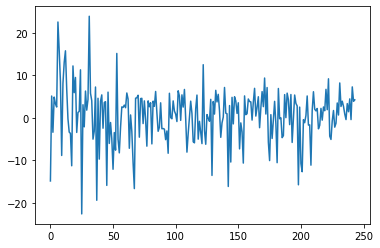

In [244]:
# Calculate Z-Score of Train set
initialFeatures = list(train_df_imdb.drop(dropColumns, axis=1).columns)
numRows = new_X_train_imdb.shape[0]
X_imdb_standardized = (new_X_train_imdb - new_X_train_imdb.mean(axis=0)) / new_X_train_imdb.std(axis=0)
y_imdb_standardized = (new_y_train_df_imdb - y_imdb_train.mean(axis=0)) / new_y_train_df_imdb.std(axis=0)

z_scores_train = (X_imdb_standardized.T @ y_imdb_standardized) / np.sqrt(numRows)
plt.plot(z_scores_train)
index_features_zscores = []
for index, (feature, zscore) in enumerate(zip(initialFeatures, z_scores_train)):
    index_features_zscores.append((index, feature, zscore))
print("Initial features:", index_features_zscores)
keptIndices, indicesForRemoval = filter(z_scores_train, 7, -7)

final_features_index_features_zscores = []
for index, item in enumerate(index_features_zscores):
    if index in keptIndices:
        final_features_index_features_zscores.append(item)
sorted_final_features_index_features_zscores = sorted(final_features_index_features_zscores, key=lambda tup: tup[2])
most_positive_final_features_index_features_zscores = sorted_final_features_index_features_zscores[-10:]
most_negative_final_features_index_features_zscores = sorted_final_features_index_features_zscores[:10]
top_zscores = most_negative_final_features_index_features_zscores + most_positive_final_features_index_features_zscores

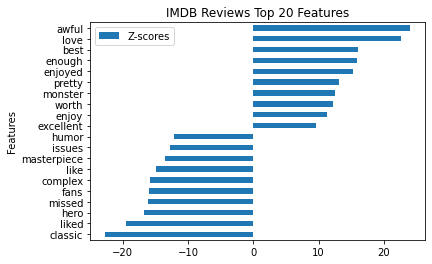

In [245]:
features = list(list(zip(*top_zscores))[1])
zscores = list(list(zip(*top_zscores))[2])

# Create data frame
zscoreData = {"Features": features, "Z-scores": zscores}
zscoreDF = pd.DataFrame(data=zscoreData);
 
# Plot graph
zscoreDF.plot.barh(x='Features', y='Z-scores', title="IMDB Reviews Top 20 Features");
plt.show(block=True)

In [246]:
# Feature-scaled train datasets
X_imdb_filtered_train_part9 = removeColumns(new_X_train_imdb, keptIndices)
y_imdb_filtered_train_part9 = new_y_train_df_imdb

X_imdb_filtered_test_part9 = removeColumns(new_X_test_imdb, keptIndices)
y_imdb_filtered_test_part9 = new_y_test_df_imdb

In [247]:
classifier = LogisticRegression(learningRate=best_valid_alpha_logistic, maxIterations=1000)
classifier.fit(X_imdb_filtered_train_part9, y_imdb_filtered_train_part9)
probabilities, predictionClasses = classifier.predict(X_imdb_filtered_test_part9)
accuracy = np.sum(y_imdb_filtered_test_part9 == predictionClasses) / len(y_imdb_filtered_test_part9)
print("Logistic Regression prediction accuracy for newly filtered features z-score filtered features: ", accuracy)

Logistic Regression prediction accuracy for newly filtered features z-score filtered features:  0.69032
